In [1]:
# Importing the required modules
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from matplotlib import pyplot as plt

from collections import OrderedDict
import numpy as np

In [2]:
# Applying transformations on images
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#Loading training and testing set
trainset = datasets.MNIST('MNIST_data/', train=True, download=True, transform=transform)
testset = datasets.MNIST('MNIST_data/', train=False, download=True, transform=transform)

#size of validation dataset
valid_size = 0.2
# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [9]:
# Defining model
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(784, 128)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(128, 64)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('fc3', nn.Linear(64, 10)),
    ('log_soft1', nn.LogSoftmax(dim=1))
]))

model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (log_soft1): LogSoftmax()
)

In [10]:
# setting the criterion as Negative Log Likelihood Loss
criterion = nn.NLLLoss()
# setting the optimizer to Stocastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [11]:
epochs = 40
running_loss = 0
min_valid_loss = np.Inf

steps = 0
print_every = 500

for e in range(epochs):
    model.train()
    
    for images, labels in trainloader:
        steps += 1
        
        # This step will change the shape of images from (64,1,28,28) to (64, 784)
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        # feed-forward
        logits = model(images)
        
        #calculating the loss
        loss = criterion(logits, labels)
        
        # Doing backward propagation of loss
        loss.backward()
        
        # Updating the weights
        optimizer.step()
        
        running_loss += loss.item()
        
    
    #validation
    model.eval()
    valid_loss = 0
    accuracy = 0
    for images, labels in validloader:
        images = images.view(images.shape[0], -1)

        logps = model(images)
        valid_loss += criterion(logps, labels).item()
        ps = torch.exp(logps)

        out_class, out_p = ps.topk(1)
        equality = labels==out_p.view(*labels.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor))
        

            
    print('Epochs: {}/{} .. Training Loss: {:.3f} .. Valid Loss: {:.3f} .. Accuracy: {:.3f}'.format(e+1, \
                                                                                                     epochs, \
                                                                                                     running_loss/len(trainloader), \
                                                                                                     valid_loss/len(validloader), \
                                                                                                     accuracy/len(validloader)))
    if valid_loss <= min_valid_loss:
        print('Validation loss decreased ({:.3f})->({:.3f}) .. saving model'.format(min_valid_loss/len(validloader), \
                                                                                    valid_loss/len(validloader)))
        torch.save(model.state_dict(), 'checkpoint.pth')
        min_valid_loss = valid_loss
    running_loss=0

Epochs: 1/40 .. Training Loss: 2.074 .. Valid Loss: 1.665 .. Accuracy: 0.572
Validation loss decreased (inf)->(1.665) .. saving model
Epochs: 2/40 .. Training Loss: 1.358 .. Valid Loss: 0.959 .. Accuracy: 0.751
Validation loss decreased (1.665)->(0.959) .. saving model
Epochs: 3/40 .. Training Loss: 0.948 .. Valid Loss: 0.695 .. Accuracy: 0.814
Validation loss decreased (0.959)->(0.695) .. saving model
Epochs: 4/40 .. Training Loss: 0.761 .. Valid Loss: 0.569 .. Accuracy: 0.849
Validation loss decreased (0.695)->(0.569) .. saving model
Epochs: 5/40 .. Training Loss: 0.647 .. Valid Loss: 0.490 .. Accuracy: 0.867
Validation loss decreased (0.569)->(0.490) .. saving model
Epochs: 6/40 .. Training Loss: 0.580 .. Valid Loss: 0.442 .. Accuracy: 0.879
Validation loss decreased (0.490)->(0.442) .. saving model
Epochs: 7/40 .. Training Loss: 0.531 .. Valid Loss: 0.409 .. Accuracy: 0.889
Validation loss decreased (0.442)->(0.409) .. saving model
Epochs: 8/40 .. Training Loss: 0.496 .. Valid Loss

We can see that our validation and training loss still decreases even on the 40th epoch. We could even train the model for more number of epochs and expect good accuracy.

In [13]:
#loading the saved model
model.load_state_dict(torch.load('checkpoint.pth'))

In [14]:
#testing the model on test data

testing_loss = 0
accuracy = 0

for images, labels in testloader:
    images = images.view(images.shape[0], -1)
    
    logps = model(images)
    loss = criterion(logps, labels)
    ps = torch.exp(logps)
    
    out_class, out_p = ps.topk(1)
    equality = labels==out_p.view(*labels.shape)
    accuracy += torch.mean(equality.type(torch.FloatTensor))
    testing_loss +=loss

print('Loss on testing data: {:.3f}\nAccuracy on testing data:{:.3f}'.format(testing_loss/len(testloader), accuracy/len(testloader)))

Loss on testing data: 0.159
Accuracy on testing data:0.953


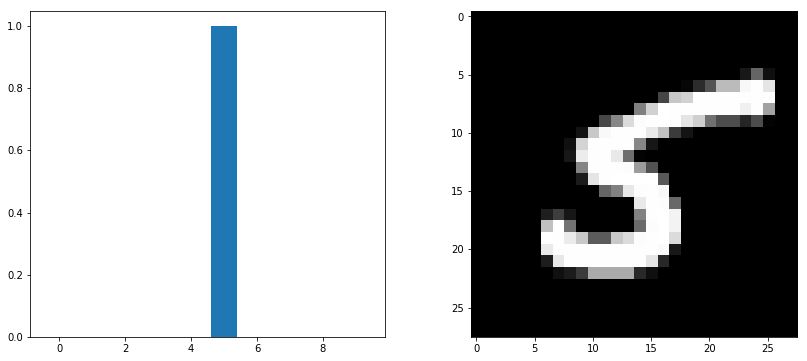

In [15]:
images, labels = next(iter(testloader))

# changing the shape of images[0] from (1,28,28) to (1,784)
img = images[0].view(1,-1)

# Defined a figure of size(14,6)
plt.figure(figsize=[14,6])

# forward passing the 'img'
logits = model(img)
# using torch.exp() gives out model gives outputs as los_softmax and doing exp() we will get original values.
output = torch.exp(logits)

# converts 'output' tensor to numpy array
y = output.detach().numpy()
N = y.shape[1]
x = np.arange(N)

# Sub plot 1st of plots with 1 row and 2 columns
plt.subplot(1,2,1)
plt.bar(x,y.ravel())


# Sub plot 2nd of plots with 1 row and 2 columns
plt.subplot(1,2,2)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')